# Skin Cancer

## 1.1 downloading the dataset

In [ ]:
import kagglehub
import shutil

path = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")
shutil.copytree(path, './data/skin-cancer')

## read and resize

In [118]:
import tensorflow as tf

# tf.keras.utils.image
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  validation_split=0.3,
  subset="validation",
  color_mode='rgb',
  seed=123,
  image_size=(30, 30),
  batch_size=32,
  shuffle=True)

train_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  validation_split=0.3,
  subset="training",
  color_mode='rgb',
  seed=123,
  image_size=(30, 30),
  batch_size=32,
  shuffle=True)

Found 3297 files belonging to 2 classes.
Using 989 files for validation.
Found 3297 files belonging to 2 classes.
Using 2308 files for training.


In [119]:
test_ds = val_ds.skip(len(val_ds)//2)
val_ds = val_ds.take(len(val_ds)//2)

In [120]:
len(val_ds)

15

In [121]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_data(dataset, datagen):
    augmented_data = []
    for images, labels in dataset:
        for i in range(images.shape[0]):
            augmented = datagen.random_transform(images[i].numpy())
            augmented_data.append((augmented, labels[i].numpy()))
            augmented_data.append((images[i].numpy(), labels[i].numpy()))
    return augmented_data

augmented_val_data = augment_data(val_ds, datagen)
augmented_train_data = augment_data(train_ds, datagen)

def to_tf_dataset(augmented_data):
    images, labels = zip(*augmented_data)
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)
    return tf.data.Dataset.from_tensor_slices((images, labels))

val_ds = to_tf_dataset(augmented_val_data).batch(32)
train_ds = to_tf_dataset(augmented_train_data).batch(32)


In [122]:
len(val_ds)

30

## normalization

In [123]:
import matplotlib.pyplot as plt

def preprocess_image(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

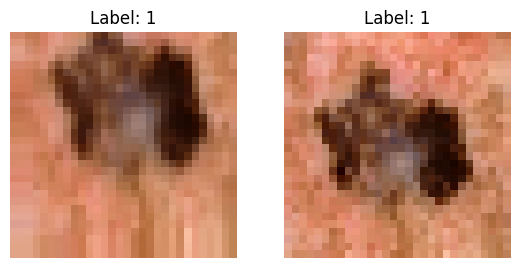

In [124]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(2):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    plt.show()

## no augmentation yet

## model

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu', use_bias=True))
model.add(Dense(units=32, activation='relu', use_bias=True))
model.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,385 (517.13 KB)

 Trainable params: 132,385 (517.13 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=128)

test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6254 - loss: 0.6325 - val_accuracy: 0.7948 - val_loss: 0.4470
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7415 - loss: 0.4881 - val_accuracy: 0.8021 - val_loss: 0.3918
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7522 - loss: 0.4812 - val_accuracy: 0.8073 - val_loss: 0.3952
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7711 - loss: 0.4424 - val_accuracy: 0.8094 - val_loss: 0.3673
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7688 - loss: 0.4428 - val_accuracy: 0.7698 - val_loss: 0.4013
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7831 - loss: 0.4445 - val_accuracy: 0.8271 - val_loss: 0.3609
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7919 - loss: 0.3997 - val_accuracy: 0.7979 - val_loss: 0.3719
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7908 - loss: 0.4142 - val_accuracy: 0.

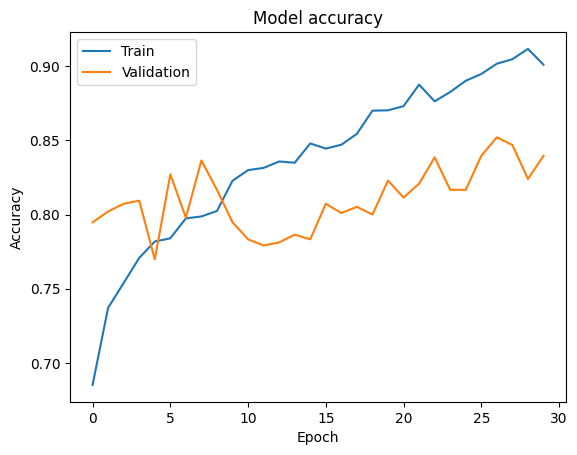

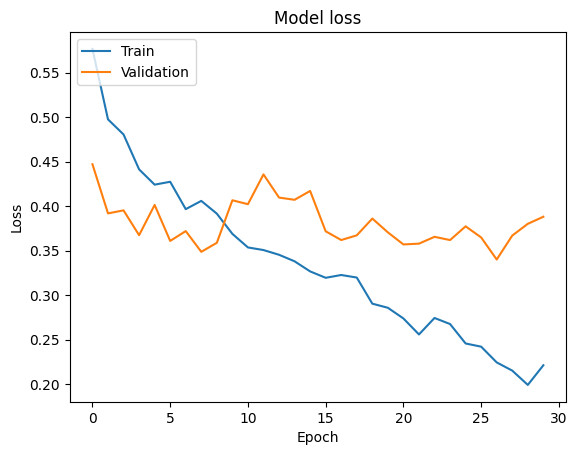

In [147]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


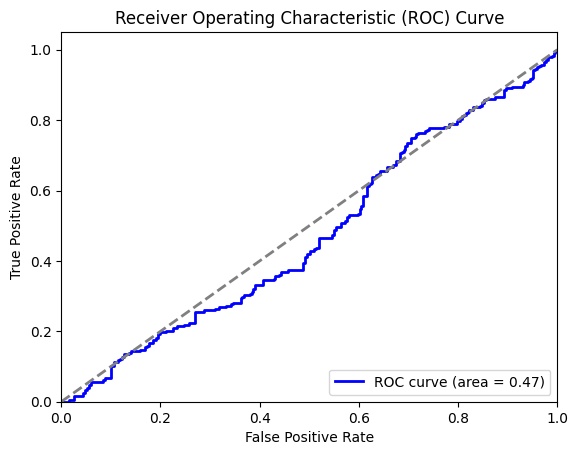

In [148]:
import numpy as np
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([y for x, y in test_ds], axis=0) 
y_pred_proba = myModel.predict(test_ds).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
roc_auc = auc(fpr, tpr)
plt.figure() 
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right")

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

myModel = Sequential()

myModel.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2),padding="same"))

myModel.add(Dropout(0.4))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Flatten())

myModel.add(Dense(units=32, activation='relu', use_bias=True))
myModel.add(Dense(units=8, activation='relu', use_bias=True))
myModel.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

myModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

myModel.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 14, 14, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 2, 2, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,009 (269.57 KB)

 Trainable params: 69,009 (269.57 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
history = myModel.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

test_loss, test_acc = myModel.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5879 - loss: 0.6658 - val_accuracy: 0.7615 - val_loss: 0.5045
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7301 - loss: 0.5416 - val_accuracy: 0.7740 - val_loss: 0.4424
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7627 - loss: 0.4817 - val_accuracy: 0.7937 - val_loss: 0.4238
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7630 - loss: 0.4725 - val_accuracy: 0.8083 - val_loss: 0.4026
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7690 - loss: 0.4401 - val_accuracy: 0.8021 - val_loss: 0.3993
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7841 - loss: 0.4303 - val_accuracy: 0.8323 - val_loss: 0.3885
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7790 - loss: 0.4290 - val_accuracy: 0.7500 - val_loss: 0.4254
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7798 - loss: 0.4270 - val_accuracy: 0.

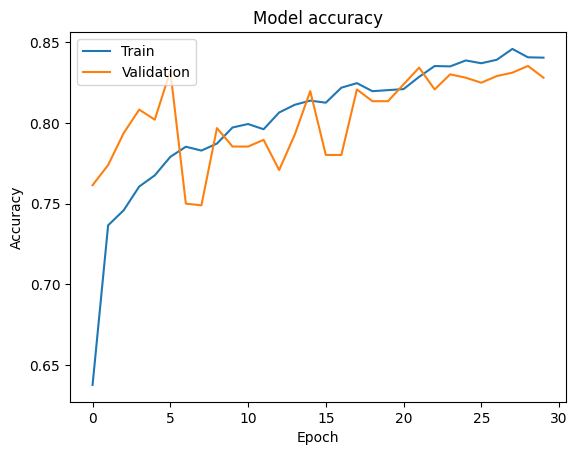

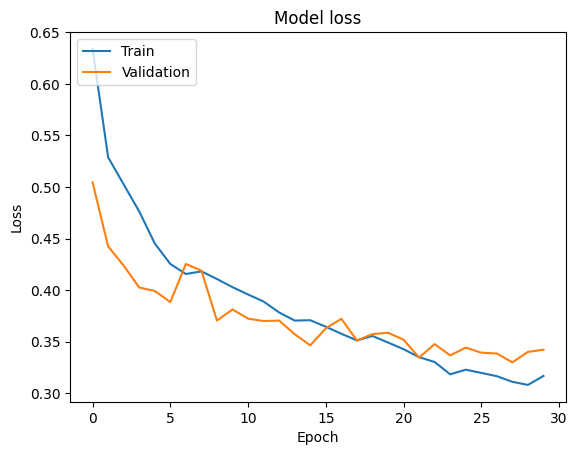

In [151]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


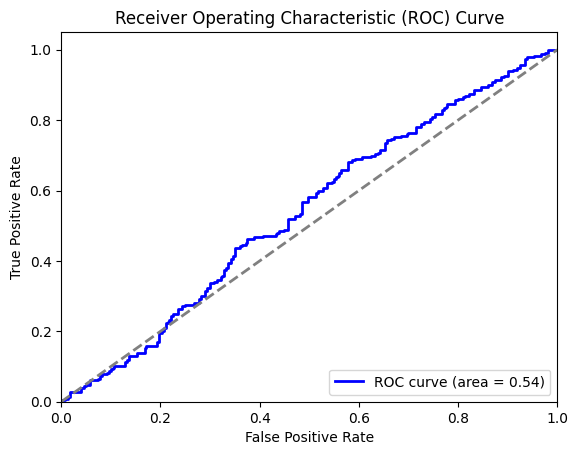

In [152]:
import numpy as np
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([y for x, y in test_ds], axis=0) 
y_pred_proba = myModel.predict(test_ds).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
roc_auc = auc(fpr, tpr)
plt.figure() 
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right")